#Instalación de Dependencias

In [1]:
!pip install pandas matplotlib seaborn scikit-learn

#Configuración Inicial

In [2]:
import os

# Creación de directorios para datos
os.makedirs("data/raw", exist_ok=True)      # Bronze
os.makedirs("data/silver", exist_ok=True)   # Silver
os.makedirs("data/gold", exist_ok=True)     # Gold

#Descarga de Datos

In [3]:
import os
import requests
from datetime import datetime, timedelta

def download_github_archives(start_date, end_date, output_dir="data/raw"):
    """Descarga archivos .json.gz de GitHub Archive por horas entre fechas"""
    os.makedirs(output_dir, exist_ok=True)
    current = start_date

    while current <= end_date:
        hour_str = current.strftime("%Y-%m-%d-%H")
        url = f"https://data.gharchive.org/{hour_str}.json.gz"
        output_path = os.path.join(output_dir, f"{hour_str}.json.gz")

        if not os.path.exists(output_path):
            print(f"Downloading {url} ...")
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
                print(f"Saved to {output_path}")
            else:
                print(f"Failed to download {url} (status code {response.status_code})")
        else:
            print(f"File {output_path} already exists. Skipping.")

        current += timedelta(hours=1)

# Ejemplo: descargar datos de 1 día (24 archivos)
start = datetime(2024, 1, 1, 0)
end = datetime(2024, 1, 1, 23)

download_github_archives(start, end)

Failed to download https://data.gharchive.org/2024-01-01-00.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-01.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-02.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-03.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-04.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-05.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-06.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-07.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-08.json.gz (status code 404)
Failed to download https://data.gharchive.org/2024-01-01-09.json.gz (status code 404)
File data/raw/2024-01-01-10.json.gz already exists. Skipping.
File data/raw/2024-01-01-11.json.gz already exists. Skipping.
File data/raw/20

#Carga y Procesamiento Inicial de Datos

In [4]:
import gzip
import json
import pandas as pd
import os

def load_github_events_from_folder(folder_path, max_files=5):
    """Carga y analiza eventos de GitHub desde archivos .json.gz en una carpeta"""
    events = []

    files = sorted(os.listdir(folder_path))
    count = 0

    for file_name in files:
        if file_name.endswith(".json.gz"):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing {file_path}...")

            with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                for line in f:
                    try:
                        event = json.loads(line)
                        events.append(event)
                    except json.JSONDecodeError:
                        continue

            count += 1
            if count >= max_files:
                break

    return pd.DataFrame(events)

# Cargar los primeros 5 archivos
df_events = load_github_events_from_folder("data/raw", max_files=5)

# Mostrar resumen
print(f"Total events loaded: {len(df_events)}")
df_events.head()

Processing data/raw/2024-01-01-10.json.gz...
Processing data/raw/2024-01-01-11.json.gz...
Processing data/raw/2024-01-01-12.json.gz...
Processing data/raw/2024-01-01-13.json.gz...
Processing data/raw/2024-01-01-14.json.gz...
Total events loaded: 911280


,id,type,actor,repo,payload,public,created_at,org
0,34499804532,PushEvent,"{'id': 155086563, 'login': 'appref5555ix63', '...","{'id': 737072655, 'name': 'appref5555ix63/Repo...","{'repository_id': 737072655, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
1,34499804536,PushEvent,"{'id': 148035012, 'login': 'RITIK-coder-1', 'd...","{'id': 721691955, 'name': 'RITIK-coder-1/Web-D...","{'repository_id': 721691955, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
2,34499804537,PushEvent,"{'id': 40938902, 'login': 'Cezary924', 'displa...","{'id': 722578722, 'name': 'Cezary924/Homebridg...","{'repository_id': 722578722, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
3,34499804549,PushEvent,"{'id': 155086649, 'login': 'dim12512a', 'displ...","{'id': 737073790, 'name': 'dim12512a/Repo7', '...","{'repository_id': 737073790, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN
4,34499804550,PushEvent,"{'id': 155086563, 'login': 'appref5555ix63', '...","{'id': 737072686, 'name': 'appref5555ix63/Repo...","{'repository_id': 737072686, 'push_id': 164644...",True,2024-01-01T10:00:00Z,NaN


#Transformación a Datos Silver

In [5]:
def transform_to_silver(df_raw):
    """
    Transforma los datos RAW en formato Silver:
    - Filtra columnas clave
    - Normaliza campos
    - Elimina nulos
    - Excluye bots
    """
    # Copia del dataframe original
    df = df_raw.copy()

    # Filtrar eventos sin tipo
    df = df[df['type'].notnull()]

    # Extraer nombre del repositorio
    df['repo_name'] = df['repo'].apply(lambda r: r.get('name') if isinstance(r, dict) else None)

    # Extraer login del usuario
    df['user_login'] = df['actor'].apply(lambda a: a.get('login') if isinstance(a, dict) else None)

    # Convertir timestamps a datetime
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

    # Eliminar filas con datos faltantes en campos críticos
    df = df.dropna(subset=['created_at', 'repo_name', 'user_login'])

    # Excluir bots por nombre de usuario
    df = df[~df['user_login'].str.contains('bot', case=False, na=False)]

    # Selección de columnas finales
    silver_cols = ['id', 'type', 'created_at', 'repo_name', 'user_login']
    df_silver = df[silver_cols]

    # Guardar versión silver
    df_silver.to_csv("data/silver/events_silver.csv", index=False)

    return df_silver

# Aplicar transformación
df_silver = transform_to_silver(df_events)

# Vista previa
df_silver.head()


,id,type,created_at,repo_name,user_login
0,34499804532,PushEvent,2024-01-01 10:00:00+00:00,appref5555ix63/Repo1,appref5555ix63
1,34499804536,PushEvent,2024-01-01 10:00:00+00:00,RITIK-coder-1/Web-Development,RITIK-coder-1
2,34499804537,PushEvent,2024-01-01 10:00:00+00:00,Cezary924/Homebridge-Automation-Bot,Cezary924
3,34499804549,PushEvent,2024-01-01 10:00:00+00:00,dim12512a/Repo7,dim12512a
4,34499804550,PushEvent,2024-01-01 10:00:00+00:00,appref5555ix63/Repo2,appref5555ix63


In [6]:

# Guardar los datos en CSV y JSON
df_silver.to_csv("data/silver/github_clean.csv", index=False)
df_silver.to_json("data/silver/github_clean.json", orient='records')

print("✅ Datos guardados exitosamente en formato CSV y JSON en la carpeta data/silver.")


✅ Datos guardados exitosamente en formato CSV y JSON en la carpeta data/silver.


#Generación de Datos Gold y Visualizaciones

Top users: user_login
dim12512a          64682
appref5555ix63     64173
lu146enza          16195
bommix              9991
mdmaid69            8466
ColeMalinchock1     6354
B74LABgit           5734
direwolf-github     4191
yanonono            3381
sSsiRMoHaMMaD       3166
Name: count, dtype: int64


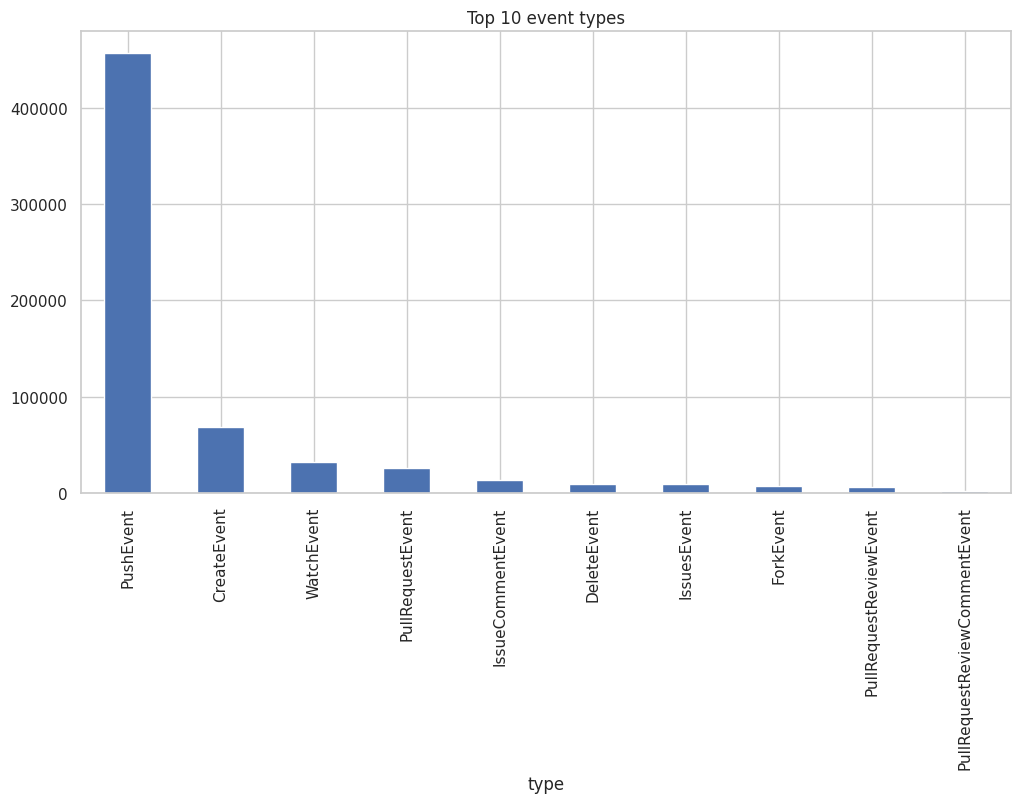

In [11]:
def generate_gold_outputs(df):
    # Eventos por tipo
    top_types = df['type'].value_counts().head(10)
    top_types.plot(kind='bar', title="Top 10 event types")

    # Usuarios más activos
    top_users = df['user_login'].value_counts().head(10)
    print("Top users:", top_users)

generate_gold_outputs(df_silver)

In [19]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Streamlit page config
st.set_page_config(page_title="GitHub Activity Dashboard", layout="wide")

st.title("📊 GitHub Activity Dashboard")

@st.cache_data
 def load_data(uploaded_file):
    df = pd.read_csv(uploaded_file, parse_dates=['created_at'])
    # Ensure datetime and derive helper columns
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.floor('D')
    df['hour'] = df['created_at'].dt.hour
    df['day_of_week'] = df['created_at'].dt.day_name()
    # Extract language
    df['language'] = df['repo_name'].str.split('/').str[-1]
    df['language'] = df['language'].str.replace(r'[^a-zA-Z]', '', regex=True)
    df = df[df['language'].str.len() > 0]
    return df

# Sidebar: file upload
uploaded_file = st.sidebar.file_uploader("Upload your GitHub events CSV", type=['csv'])
if not uploaded_file:
    st.info("Please upload a CSV file containing columns: created_at, repo_name, user_login, type.")
    st.stop()

df_silver = load_data(uploaded_file)

# Set seaborn style
sns.set_style('whitegrid')

# Colors
def get_colors(n):
    return sns.color_palette('viridis', n)

# 1. Top 10 Trending Repositories (3-day Rolling Average)
st.header("1. Top 10 Trending Repositories")
# Compute counts
repo_counts = df_silver.groupby(['date', 'repo_name']).size().reset_index(name='event_count')
repo_totals = repo_counts.groupby('repo_name')['event_count'].sum()
top_repos = repo_totals.nlargest(10).index.tolist()

pivot_repos = (
    repo_counts[repo_counts['repo_name'].isin(top_repos)]
    .pivot(index='date', columns='repo_name', values='event_count')
    .fillna(0)
    .rolling(window=3, min_periods=1)
    .mean()
)

fig1, ax1 = plt.subplots(figsize=(10, 5))
pivot_repos.plot(ax=ax1, linewidth=2.2, color=get_colors(len(top_repos)))
ax1.set_title('Top 10 Trending GitHub Repositories (3-day Rolling Average)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Events')
ax1.legend(title='Repository', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30)
st.pyplot(fig1)

# 2. Trending Programming Languages (Stacked Area)
st.header("2. Trending Programming Languages")
lang_counts = df_silver.groupby(['date', 'language']).size().reset_index(name='count')
lang_totals = lang_counts.groupby('language')['count'].sum()
top_langs = lang_totals.nlargest(8).index.tolist()

pivot_langs = (
    lang_counts[lang_counts['language'].isin(top_langs)]
    .pivot(index='date', columns='language', values='count')
    .fillna(0)
    .rolling(window=3, min_periods=1)
    .mean()
)

# Percent stacked
pivot_pct = pivot_langs.div(pivot_langs.sum(axis=1), axis=0) * 100
fig2, ax2 = plt.subplots(figsize=(10, 5))
pivot_pct.plot.area(ax=ax2, stacked=True, alpha=0.8, colormap='viridis')
ax2.set_title('Trending Programming Languages (% of Total)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Percentage (%)')
ax2.legend(title='Language', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30)
st.pyplot(fig2)

# 3. Weekly Activity of Top Users (Non-Bot)
st.header("3. Weekly Activity of Top GitHub Users")
bot_patterns = ['bot', 'Bot', 'BOT', 'automation', 'github-actions', 'dependabot']
mask = df_silver['user_login'].apply(lambda x: not any(p in str(x) for p in bot_patterns))
df_users = df_silver[mask]
user_counts = df_users.groupby(['date', 'user_login']).size().reset_index(name='activity')
top_users = user_counts.groupby('user_login')['activity'].sum().nlargest(5).index.tolist()

weekly = (
    user_counts[user_counts['user_login'].isin(top_users)]
    .pivot(index='date', columns='user_login', values='activity')
    .fillna(0)
    .resample('W').sum()
)

fig3, ax3 = plt.subplots(figsize=(10, 5))
weekly.plot.bar(ax=ax3, width=0.8)
for user in weekly.columns:
    coeff = np.polyfit(range(len(weekly)), weekly[user], 1)
    trend = np.poly1d(coeff)(range(len(weekly)))
    ax3.plot(range(len(weekly)), trend, '--', linewidth=2)
ax3.set_title('Weekly Activity of Top GitHub Users')
ax3.set_xlabel('Week')
ax3.set_ylabel('Events')
ax3.set_xticklabels([d.strftime('%Y-%m-%d') for d in weekly.index], rotation=45)
ax3.legend(title='User', bbox_to_anchor=(1.02, 1), loc='upper left')
st.pyplot(fig3)

# 4. Activity Heatmap by Day and Hour
st.header("4. Activity Heatmap by Hour and Day of Week")
heatmap_data = (
    df_silver.groupby(['day_of_week', 'hour']).size()
    .unstack(fill_value=0)
    .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
)
fig4, ax4 = plt.subplots(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, linewidths=0.5, ax=ax4)
ax4.set_title('GitHub Activity by Day & Hour')
ax4.set_xlabel('Hour')
ax4.set_ylabel('Day of Week')
st.pyplot(fig4)

st.sidebar.markdown("---")
st.sidebar.write("Built with ❤️ using Streamlit")


IndentationError: unexpected indent (<ipython-input-19-414843ce7397>, line 14)

In [21]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [23]:
import pandas as pd, gzip, json
from pathlib import Path
import dash
from dash import dcc, html
import plotly.express as px

def load_data(path="data/raw"):
    rows = []
    for file in Path(path).glob("*.json.gz"):
        with gzip.open(file, 'rt', encoding='utf-8') as f:
            for line in f:
                e = json.loads(line)
                rows.append({
                    'created_at': e.get('created_at'),
                    'type': e.get('type'),
                    'repo': e.get('repo', {}).get('name'),
                    'actor': e.get('actor', {}).get('login')
                })
    df = pd.DataFrame(rows).dropna()
    df['created_at'] = pd.to_datetime(df['created_at'])
    return df

df = load_data()

top_events = df['type'].value_counts().nlargest(5)
top_repos = df['repo'].value_counts().nlargest(5)
top_users = df['actor'].value_counts().nlargest(5)
events_by_hour = df.set_index('created_at').resample('h').size().reset_index(name='count')

app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("GitHub Activity Dashboard"),
    dcc.Graph(figure=px.bar(top_events, title="Eventos más frecuentes", labels={'value': 'Eventos', 'index': 'Tipo'})),
    dcc.Graph(figure=px.bar(top_repos, title="Repositorios con más actividad", labels={'value': 'Eventos', 'index': 'Repositorio'})),
    dcc.Graph(figure=px.bar(top_users, title="Usuarios más activos", labels={'value': 'Eventos', 'index': 'Usuario'})),
    dcc.Graph(figure=px.line(events_by_hour, x='created_at', y='count', title="Eventos por hora"))
])

if __name__ == "__main__":
    app.run(debug=True)


<IPython.core.display.Javascript object>